This code is from my 378 Final Project from last year. Our project was to predict the genre of music (10 genre classes) given a 30 second (long!) audio clips of many songs as labeled training data.

In [ ]:
import librosa  #very popular package for music and audio analysis
import numpy as np
import matplotlib.pyplot as plt
#from scipy.spatial.distance import cdist
#from scipy.stats import mode
from scipy.signal import welch
from scipy.fft import fft, fftfreq

import csv
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Exploration (FFT & PSD)

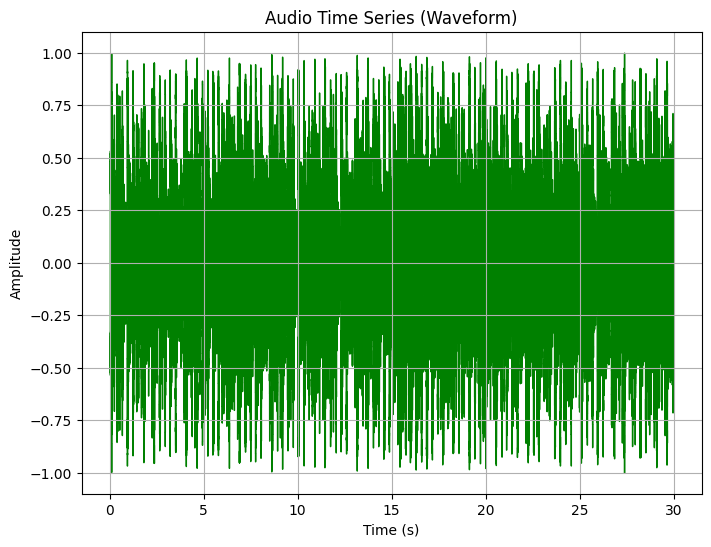

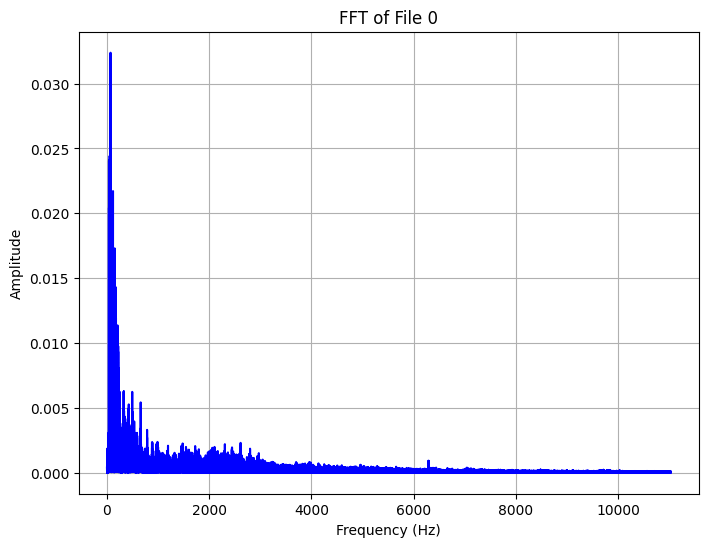

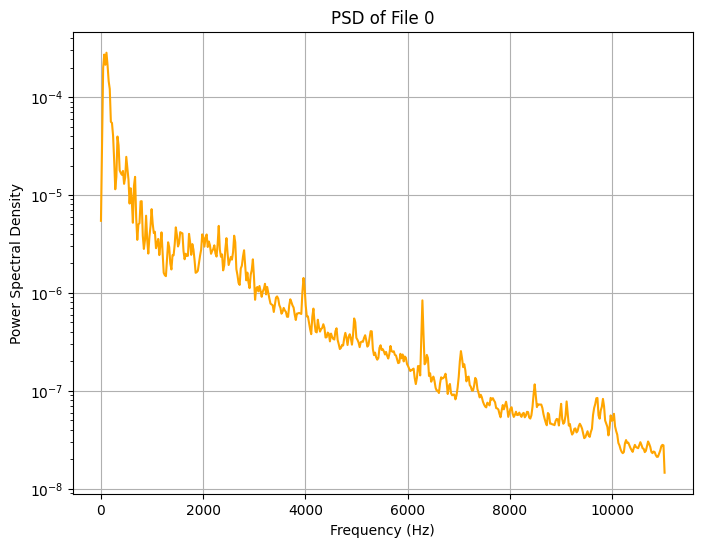

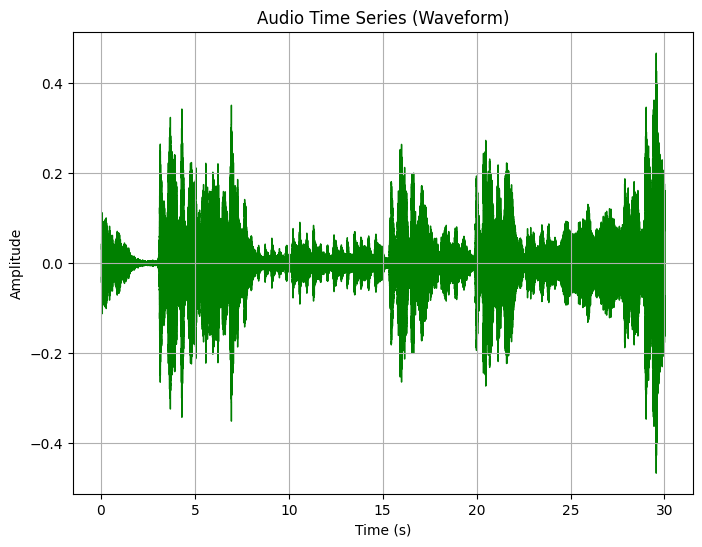

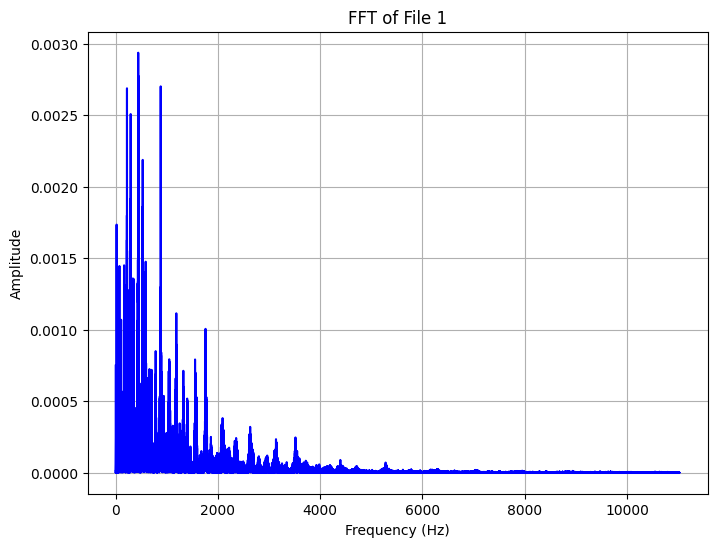

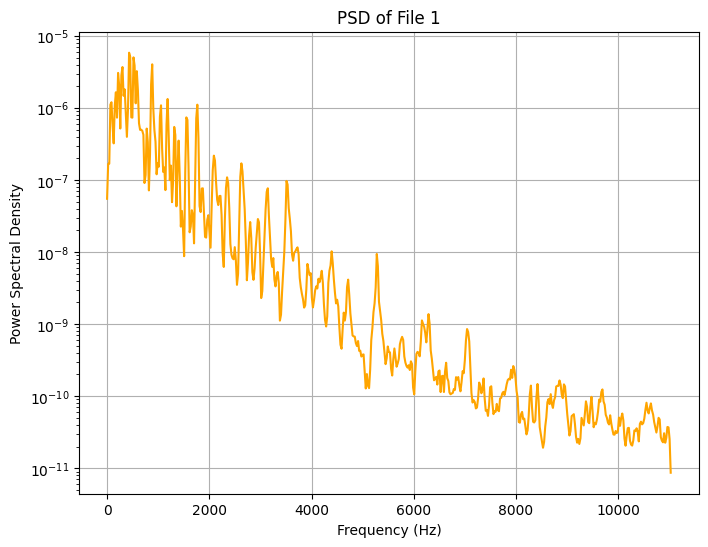

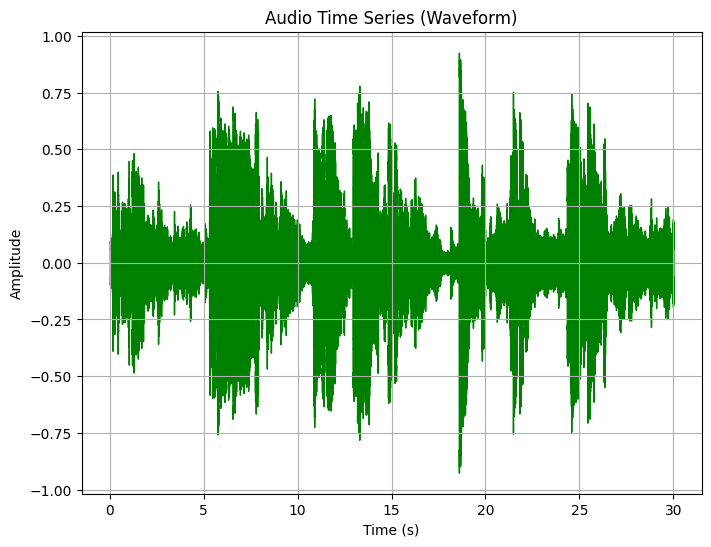

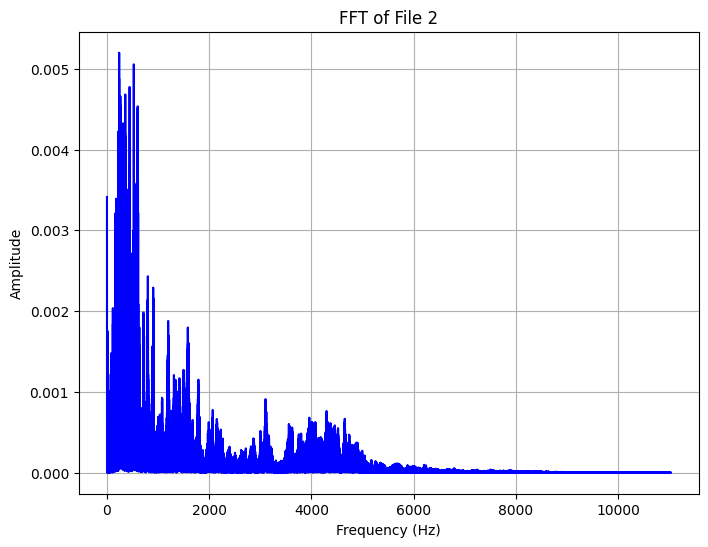

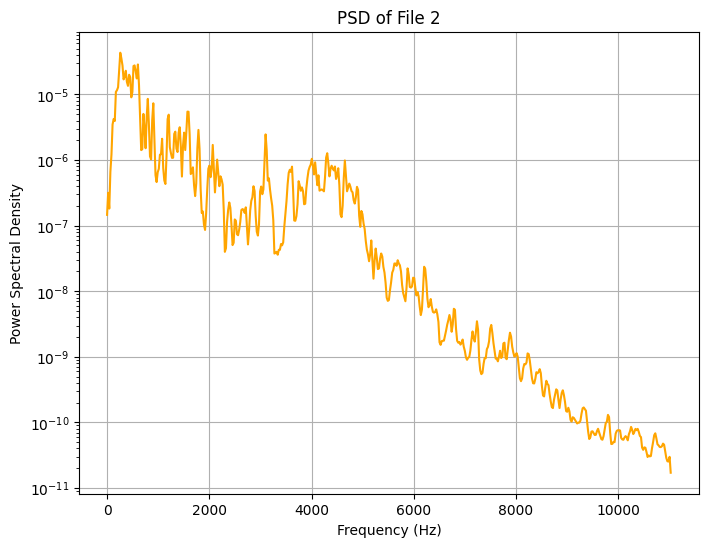

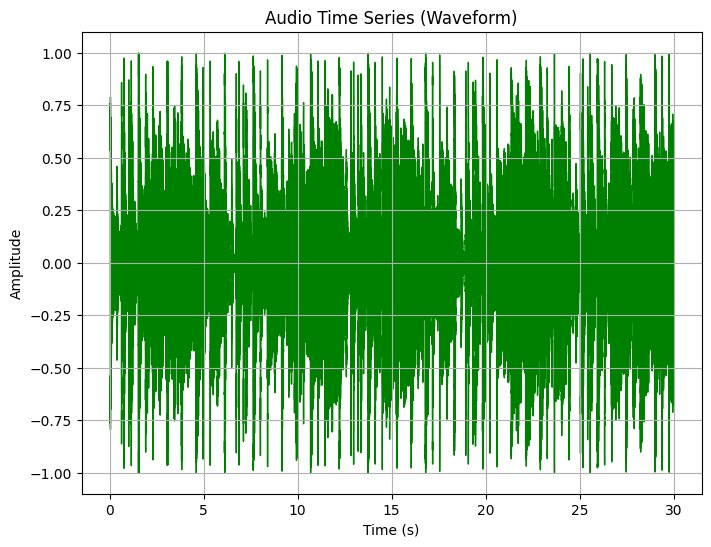

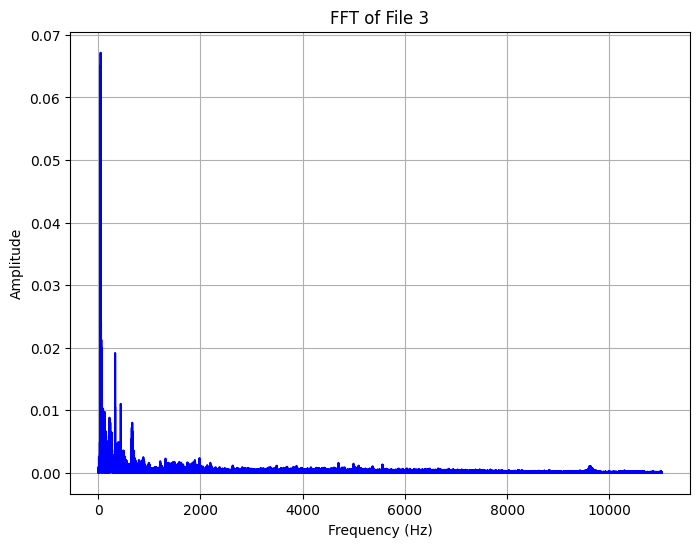

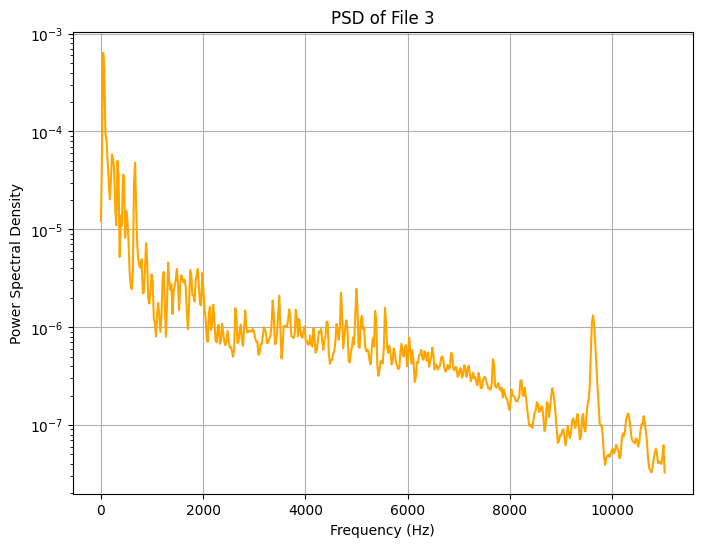

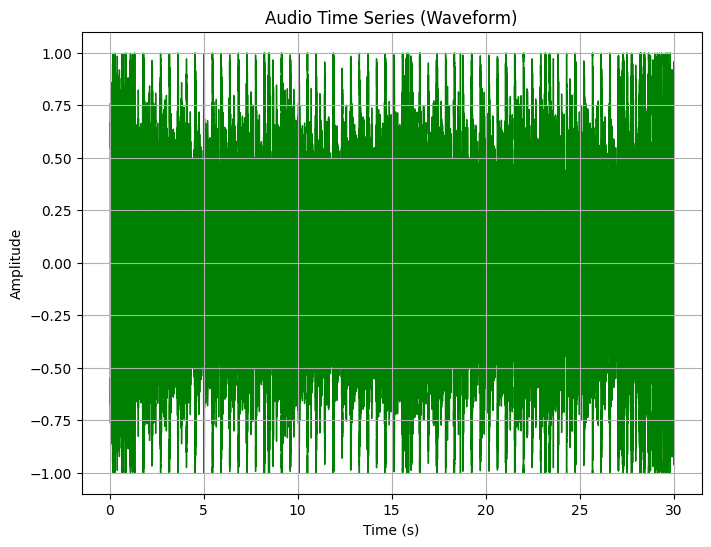

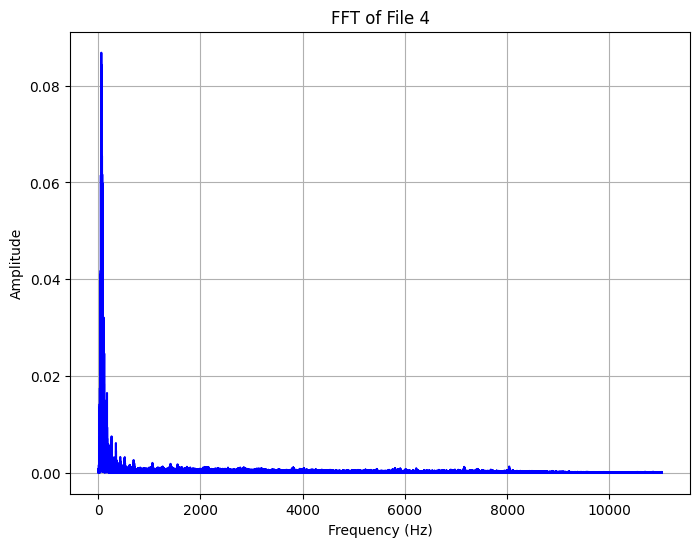

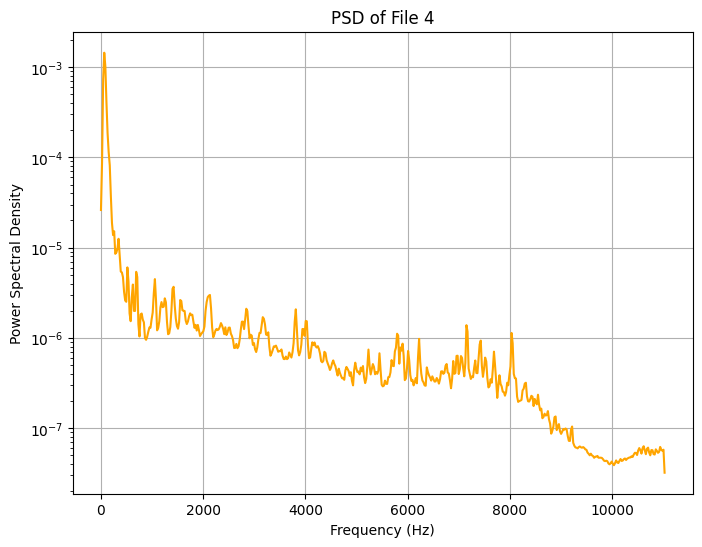

In [ ]:
# Load labels from CSV
labels = []
with open('/content/drive/My Drive/Elec378 Final Project/Dataset/train.csv', mode='r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header
    for row in reader:
        labels.append(row[1])

# Temporary: for now, lets just consider the first 5 audio files (so that we can get through tutorial fast)
labels = labels[:5]

# we would like to get a sense of the signal's properties so see what are some good features to extract
for i in range(len(labels)):
    file_name = f'/content/drive/My Drive/Elec378 Final Project/Dataset/train/train{str(i).zfill(3)}.wav'
    y, sr = librosa.load(file_name, sr=None)  # load full audio signal

    # raw audio waveform
    # Plot the waveform
    plt.figure(figsize=(8, 6))
    librosa.display.waveshow(y, sr=sr, color = 'green')
    plt.title("Audio Time Series (Waveform)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
    # fft
    N = len(y)
    yf = fft(y)
    xf = fftfreq(N, 1 / sr)[:N // 2]
    plt.figure(figsize=(8, 6))
    plt.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]), color = 'blue')
    plt.title(f"FFT of File {i}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

    # psd
    f, Pxx = welch(y, sr, nperseg=1024)
    plt.figure(figsize=(8, 6))
    plt.semilogy(f, Pxx, color = 'orange')
    plt.title(f"PSD of File {i}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid()
    plt.show()

The basic data exploration above provides intuition for extracting features or processing raw data to be in a different format that might allow for better ML models (think linear separability).

Feature Extraction (per audio signal)

In [ ]:
def extract_features(file_name, start_second, duration=3):
    try:
        # Load a segment of the audio file
        audio_timeseries, sampling_rate = librosa.load(file_name, sr=None, offset=start_second, duration=duration)

        # Extract MFCC and other features
        mfccs = librosa.feature.mfcc(y=audio_timeseries, sr=sampling_rate, n_mfcc=20)
        chroma = librosa.feature.chroma_stft(y=audio_timeseries, sr=sampling_rate)
        all_features = np.vstack([mfccs, chroma])
        librosa_features_mean = np.mean(all_features, axis=1)
        return librosa_features_mean
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return None

#Note: This is just a small sample of all the features you can extract from audio signals. Look at what the librosa library has to offer!
#Another Note: This is an example of feature extraction per data point (signal). You could also do something like PCA on all the raw
#               train data (as in directly on the audio signals) or PCA on all data as the computed features per datapoint.

Audio as Melspectograms (Hint Hint for CNNs, other image classifiers)

In [ ]:
def gen_melspec(file_path, start_second, n_mels, duration=3):
  audio_timeseries, sampling_rate = librosa.load(file_name, sr=None, offset=start_second, duration=duration)
  mel_spec = librosa.feature.melspectrogram(y=audio_timeseries, sr=sampling_rate, n_mels=n_mels)
  log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
  return log_mel_spec.flatten()
  # there are also other features that you can explore too!

Loading Features

In [ ]:
# Load dataset and extract features
features = []
labels_for_features = []

# We had long audio files, so specify duration and num of segments for splitting these long audio files
total_duration = 30
segment_duration = 3
segments_per_file = total_duration // segment_duration

for i in range(len(labels[:5])):
    file_name = f'/content/drive/My Drive/Elec378 Final Project/Dataset/train/train{str(i).zfill(3)}.wav'
    for j in range(segments_per_file):
        start_second = j * segment_duration
        extracted_features = extract_features(file_name, start_second, duration=segment_duration)
        if extracted_features is not None:
            features.append(extracted_features)
            # Each segment gets the same label which is why we need to get the labels first
            labels_for_features.append(labels[i])

print(features, labels_for_features)

[array([-3.07999954e+01,  9.16179886e+01, -1.34059963e+01,  3.27073021e+01,
        6.40903616e+00,  1.06340475e+01,  7.12790608e-01,  8.87579060e+00,
        3.35266328e+00,  2.40511298e+00,  2.67973709e+00,  5.52857971e+00,
        1.69913590e+00,  2.17846680e+00,  2.81146598e+00,  1.47298789e+00,
       -9.77555960e-02,  3.23192887e-02, -8.19208205e-01, -2.08807540e+00,
        6.48737609e-01,  4.49541897e-01,  4.85844195e-01,  5.23800015e-01,
        6.89641953e-01,  5.40091515e-01,  4.60178196e-01,  4.25985366e-01,
        4.89803880e-01,  5.73177874e-01,  5.86492717e-01,  8.16091895e-01],
      dtype=float32), array([-31.874523  ,  88.305916  , -11.160419  ,  31.138037  ,
         5.6827044 ,   8.155489  ,   0.1613992 ,   8.743342  ,
         3.9160454 ,   2.479706  ,   2.792668  ,   3.9132273 ,
         1.34423   ,   2.8596904 ,   3.0278366 ,   1.3473513 ,
        -1.3977786 ,   0.46295184,   0.396135  ,  -0.6536895 ,
         0.6718574 ,   0.49403334,   0.5146781 ,   0.5307523 

Model + Trainer

In [ ]:
# Convert to numpy arrays and continue as before
features = np.array(features)
labels_for_features = np.array(labels_for_features)
#converts labels to unique integers
#this may be optional
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_for_features)

#print('encoded labels', labels_encoded)

# Initialize cross-validation (you can use this or simple train test split although this will make testing of your model more robust!)
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []

'''
Alternatively, you can also simply use sklearn's train_test_split function!! Cross validation is K different random combinations
of this train and test data split in order to train the model more robustly and ultimately use all your available data for the kaggle competition.
'''

# SVM Model and preprocessing initialization
svm_clf = SVC(kernel='rbf', C=1, gamma='auto')
scaler = StandardScaler()
pca = PCA(n_components=0.95) #keep enough components to preserve 95% of the variance in the data

# Perform cross-validation
for train_index, test_index in kf.split(features, labels_encoded):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels_encoded[train_index], labels_encoded[test_index]
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    svm_clf.fit(X_train_pca, y_train)
    y_pred = svm_clf.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy * 100:.2f}%")

encoded labels [3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4
 4 4 4 1 1 1 1 1 1 1 1 1 1]
Average Accuracy: 98.00%


Loading and Testing Test Data

In [ ]:
test = []
duration = 10 #we were given 10 sec long test clips
segment_duration = 3
segments_per_file = 3

test_features = []

for i in range(20):  # Assuming 20 test files
    file_name = f'/content/drive/My Drive/Elec378 Final Project/Dataset/test/test{str(i).zfill(3)}.wav'
    for j in range(segments_per_file):
        start_second = j * segment_duration
        mfccs = extract_features(file_name, start_second, duration=segment_duration)
        if mfccs is not None:
            #2D array shape
            test_features.append(mfccs.reshape(1, -1))

# Convert list of arrays into a single numpy array
test_features = np.vstack(test_features)
test_scaled = scaler.transform(test_features)
test_pca = pca.transform(test_scaled)

# Predict using the SVM (with decoded predictions)
test_pred = svm_clf.predict(test_pca)
test_pred_labels = label_encoder.inverse_transform(test_pred)


# Save to a CSV for submission to Kaggle
with open('svm.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['ID', 'Genre'])
    for i, genre in enumerate(test_pred_labels):
        writer.writerow([f'test{str(i).zfill(3)}.wav', genre])


Reducing Overfitting through Recursive Feature Extraction(RFE)

RFE is a feature selection method that fits a model with the
existing features and removes the weakest feature. This fitting process is repeated until a specified
number of features remains. In this case, the model is initially fit with all the combined features. RFE ranks the features by their importance to the predictive accuracy. The least important
feature is removed recursively. The model is then refitted with the new, reduced set of features. This
process is iterated until the specified number of features is reached.

In [ ]:
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def load_data(features_path, labels_path):
    # Load features and original labels
    features = np.load(features_path)
    original_labels = np.load(labels_path)
    return features, original_labels

def train_svm_classifier(features, labels):
    scaler = StandardScaler()
    encoder = LabelEncoder()

    # Encode labels and scale features
    labels_encoded = encoder.fit_transform(labels)
    features_scaled = scaler.fit_transform(features)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features_scaled, labels_encoded, test_size=0.2, random_state=42)

    # Determine if you should use the dual formulation
    use_dual = X_train.shape[0] > X_train.shape[1]  # True if more samples than features

    # Initialize the LinearSVC model for RFE
    linear_svc = LinearSVC(dual=use_dual, max_iter=20000, tol=1e-4)

    # Feature selection with RFE using LinearSVC
    rfe = RFE(estimator=linear_svc, n_features_to_select=20, step=1, verbose=3)
    rfe.fit(X_train, y_train)

    # Transform features using RFE
    X_train_rfe = rfe.transform(X_train)
    X_val_rfe = rfe.transform(X_val)

    # Train the final model using the RBF kernel with selected features
    model = SVC(kernel='rbf', C=1, decision_function_shape='ovo', gamma='scale')
    model.fit(X_train_rfe, y_train)

    # Predict on the validation set with the reduced feature set
    y_pred = model.predict(X_val_rfe)
    validation_accuracy = accuracy_score(y_val, y_pred)
    print(f'Validation Accuracy: {validation_accuracy}')

    # Save the best model, scaler, encoder, and RFE selector
    joblib.dump(model, 'Dataset/svm_model_optimal_rfe.joblib')
    joblib.dump(scaler, 'Dataset/scaler_optimal_rfe.joblib')
    joblib.dump(encoder, 'Dataset/label_encoder_optimal_rfe.joblib')
    joblib.dump(rfe, 'Dataset/rfe_selector_optimal.joblib')

if __name__ == "__main__":
    features, labels = load_data('train_features.npy', 'train_labels.npy')
    train_svm_classifier(features, labels)

Fitting estimator with 59 features.
Fitting estimator with 58 features.


KeyboardInterrupt: 

Note on Overfitting:
Note how we tried to mitigate the overfitting problem explicitly at the end through RFE but also implicitly at several prior points in the data science pipeline. We used PCA to capture 95% variance and thus eliminate highly specfic dimensions in feature space that could potentially cause the model to overfit. We also used K-fold cross validation instead of a simple train test split in order to not make training dependent on just one random split of the available data.

Other Ways to Address Overfitting:
* Splitting train validation ratio: The dataset this year is pretty large. The typical train validation split is 80% and 20%. You can always experiment with different ratios to find better performance. However, increasing or decreasing one side too much can lead to overfitting too much to the validation data or underfitting to the validation data.
* Grid search vs random search:
  * Both are ways to tune hyperparameters of your model for better performance. However, both have benefits and downsides.
  * Grid search tries all combinations of hyperparameters in the range of values that you provide. Random search randomly samples hyperparameters in the range of values that you provide.
  * General fast rule of thumb: Use grid search when there are less hyperparameters that also have more correlation with each other. Use random search when there are too many parameters without correlation with each other to see better trends first.
* Early stopping: Use a plot to monitor the validation set performance. When the validation stops improving is when you stop training the model early before it reaches the end of the whole training iterations specified.
* Regularization: Introduce a penalty term in the loss function that prevents over-emphasis and weights on a specific parameter. Different regularization methods were covered in class: L1 (Lasso) and L2 (Ridge).
* Data augmentation: Create more data that is slightly changed from the given train set if you feel you want more training data.
* Too many features: feature selection and dimensionality reduction like PCA.

Other general tips:


*   Consider using raw audio signals vs extracted features of audio signals vs images to train your models.
*   Consider the implications about your data based on the test accuracies of models. For example, if your SVM has a poor accuracy (despite correct implementation), then that most likely implies that your data is probably ont linearly separable. In that case try using kernels or even better for your second model - neural nets!
* CNNs (very common for such tasks, although not SOTA) can be used on 1D (WaveNet), 2D (ResNet), or 3D data (many times people assume it's only for 2D images).
* Transformers are SOTA but take very long to train, especially with Colab's free GPU, so keep that in mind.
* Loading Labels (IMPORTANT): The data for this year has each emotion and their files in a separate folder each without a created train.csv to download. So, please create a train.csv with one column being the filename and second column being the corresponding emotion based on which folder the file is in.
  * NOTE: the emotion "Surprised" is spelled as "Suprised" so use "Suprised" across everything
* Submission file format: Please be aware of the format and follow the format given on Kaggle of two columns with the same column names and format with the emotions having the first letter capitalized.


